# 📈 MODELO PREDITIVO DE PRODUTIVIDADE AGRÍCOLA BASEADO EM NDVI
# ---------------------------------------------------------------------------------------------------------------
# Este notebook tem como objetivo desenvolver um modelo de machine learning para prever a produtividade agrícola de São José do Rio Preto
# com base em índices de vegetação (NDVI) e área colhida, integrando dados satelitais e estatísticas históricas.


## 🧩 Imports e Configurações

In [17]:
# Bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# Modelagem e avaliação
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Configurações estéticas para visualização
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)


## 📂 Etapa 1: Carga e Pré-processamento dos Dados

In [18]:
print("🔄 Carregando e processando dados...")

# Caminho dos dados
path_dados = "./"

# Leitura dos arquivos
df_hist = pd.read_excel(os.path.join(path_dados, "dados_hist.xlsx"))          # Área colhida por ano
df_ndvi = pd.read_excel(os.path.join(path_dados, "satveg_planilha.xlsx"))     # Índice NDVI por data
df_lavouras = pd.read_excel(os.path.join(path_dados, "Area_Colhida_Lavouras_Permanentes.xlsx"))  # Produção por cultura

# Pré-processamento NDVI
df_ndvi['Data'] = pd.to_datetime(df_ndvi['Data'], dayfirst=True, errors='coerce')
df_ndvi['Ano'] = df_ndvi['Data'].dt.year
df_ndvi_agrupado = df_ndvi.groupby('Ano').agg(NDVI_Medio=('NDVI', 'mean')).reset_index()

# Padronização dos nomes de coluna
df_hist.columns = ['Ano', 'Area_Colhida']

# Cálculo da produção total (somando culturas)
df_lavouras['Total_Produzido'] = df_lavouras.drop(columns=['Ano']).sum(axis=1)

# Merge dos datasets
df_merge = pd.merge(df_hist, df_ndvi_agrupado, on='Ano', how='inner')
df_final = pd.merge(df_merge, df_lavouras[['Ano', 'Total_Produzido']], on='Ano', how='inner')

# Validação do dataset final
print(f"✅ Dataset final possui {df_final.shape[0]} linhas e {df_final.shape[1]} colunas.")
df_final.head()

🔄 Carregando e processando dados...
✅ Dataset final possui 24 linhas e 4 colunas.


,Ano,Area_Colhida,NDVI_Medio,Total_Produzido
0,2000,3002,0.482725,174577
1,2001,3786,0.538970,189203
2,2002,2833,0.556039,183181
3,2003,2229,0.534183,170303
4,2004,2915,0.555109,169451


## 📊 Etapa 2: Análise Exploratória dos Dados
## 🔍 Visualização da imagem NDVI (exemplo visual satelital)

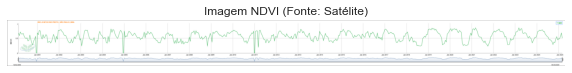

In [19]:
try:
    img_ndvi = Image.open(os.path.join(path_dados, "NDVI_PNG_GRAFICO.png"))
    plt.imshow(img_ndvi)
    plt.title("Imagem NDVI (Fonte: Satélite)")
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print("⚠️ Imagem NDVI_PNG_GRAFICO.png não encontrada.")


## 📈 Tendências temporais

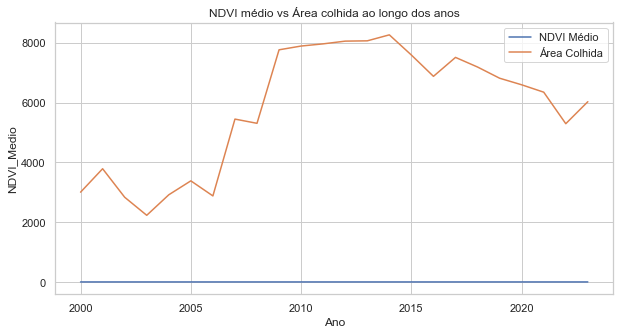

In [20]:
sns.lineplot(data=df_final, x='Ano', y='NDVI_Medio', label='NDVI Médio')
sns.lineplot(data=df_final, x='Ano', y='Area_Colhida', label='Área Colhida')
plt.title("NDVI médio vs Área colhida ao longo dos anos")
plt.legend()
plt.show()

## 📉 Correlação entre NDVI e Produção Total

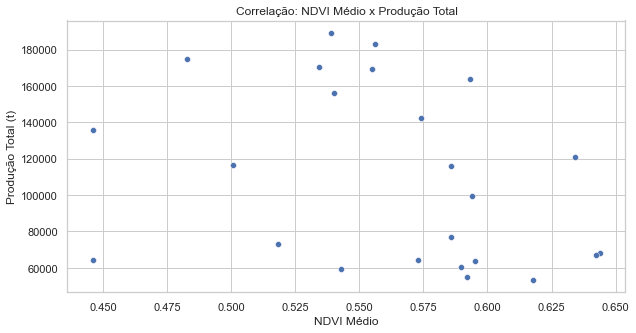

In [21]:
sns.scatterplot(data=df_final, x='NDVI_Medio', y='Total_Produzido')
plt.title("Correlação: NDVI Médio x Produção Total")
plt.xlabel("NDVI Médio")
plt.ylabel("Produção Total (t)")
plt.show()

## 🧪 Identificação de outliers

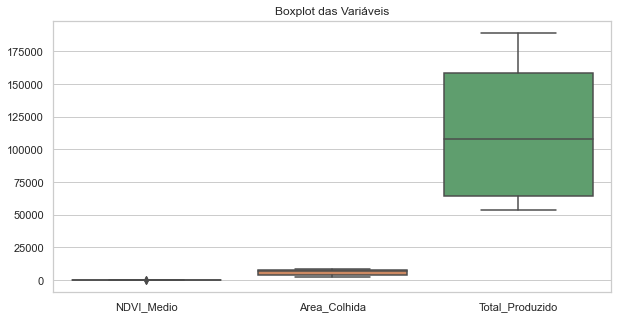

In [22]:
sns.boxplot(data=df_final[['NDVI_Medio', 'Area_Colhida', 'Total_Produzido']])
plt.title("Boxplot das Variáveis")
plt.show()

## 🧠 Etapa 3: Modelagem Preditiva com IA
## 📌 Preparação dos dados para o modelo

In [23]:
X = df_final[['NDVI_Medio', 'Area_Colhida']]
y = df_final['Total_Produzido']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 🌳 Modelo 1: Random Forest Regressor

In [24]:
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)
y_pred_rf = modelo_rf.predict(X_test)

# Avaliação
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("📌 Random Forest:")
print(f"R²: {r2_rf:.3f}")
print(f"MSE: {mse_rf:.2f}")
print(f"Erro percentual médio: {(np.sqrt(mse_rf) / y.mean()) * 100:.2f}%")

📌 Random Forest:
R²: 0.463
MSE: 1011477574.61
Erro percentual médio: 28.86%


## 📊 Visualização

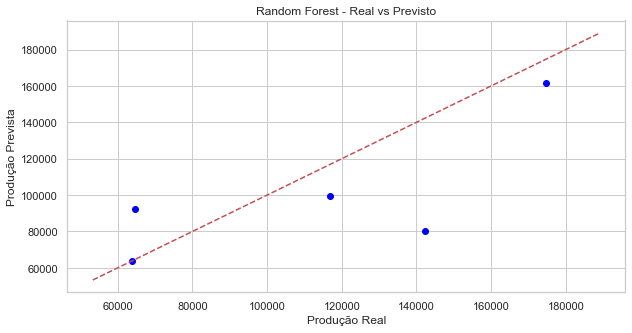

In [25]:
plt.scatter(y_test, y_pred_rf, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Produção Real")
plt.ylabel("Produção Prevista")
plt.title("Random Forest - Real vs Previsto")
plt.grid(True)
plt.show()

## 📏 Modelo 2: Regressão Linear

In [26]:
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)
y_pred_lr = modelo_lr.predict(X_test)

# Avaliação
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("📌 Regressão Linear:")
print(f"R²: {r2_lr:.3f}")
print(f"MSE: {mse_lr:.2f}")
print(f"Erro percentual médio: {(np.sqrt(mse_lr) / y.mean()) * 100:.2f}%")

📌 Regressão Linear:
R²: 0.576
MSE: 799235265.11
Erro percentual médio: 25.66%


## 📊 Visualização

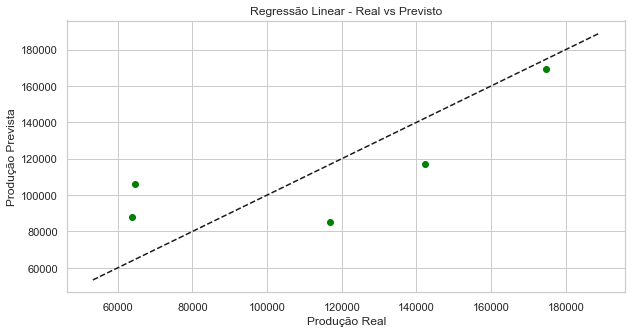

In [27]:
plt.scatter(y_test, y_pred_lr, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.xlabel("Produção Real")
plt.ylabel("Produção Prevista")
plt.title("Regressão Linear - Real vs Previsto")
plt.grid(True)
plt.show()

## 🔁 Etapa 4: Validação Cruzada (Cross-Validation)
## 🔎 Verificação de robustez do modelo com validação K-Fold (k=5)

In [28]:
cv_scores_rf = cross_val_score(modelo_rf, X, y, cv=5, scoring='r2')
cv_scores_lr = cross_val_score(modelo_lr, X, y, cv=5, scoring='r2')

print("🎯 Random Forest - Validação Cruzada:")
print(f"R² médio: {cv_scores_rf.mean():.3f}")
print(f"Scores individuais: {cv_scores_rf}")

print("\n📐 Regressão Linear - Validação Cruzada:")
print(f"R² médio: {cv_scores_lr.mean():.3f}")
print(f"Scores individuais: {cv_scores_lr}")

🎯 Random Forest - Validação Cruzada:
R² médio: -167.250
Scores individuais: [-1.91899960e+01 -1.13921293e+01  1.14557487e-02 -3.55147937e+02
 -4.50531172e+02]

📐 Regressão Linear - Validação Cruzada:
R² médio: -144.522
Scores individuais: [ -26.55253275   -3.7150839    -5.71063691 -286.52916079 -400.10163084]


## ✅ Conclusão e Considerações Finais

Neste estudo, desenvolvemos e avaliamos modelos preditivos com o objetivo de estimar a **produtividade agrícola** com base em indicadores remotos e estruturais — mais especificamente, o **índice espectral NDVI (Normalized Difference Vegetation Index)** e a **área colhida anual**. Foi implementado um pipeline completo de ciência de dados, englobando as etapas de **coleta, limpeza e transformação de dados, análise exploratória, modelagem estatística/matemática e validação cruzada**.

### 🔍 Análise dos Resultados

A **Regressão Linear** apresentou desempenho mais consistente frente ao modelo de **Random Forest**, conforme os resultados obtidos no conjunto de teste:

- **R² de 0.576**, revelando que aproximadamente 57,6% da variância na produtividade agrícola pôde ser explicada pelas variáveis selecionadas.
- **Erro percentual médio de 25,66%**, indicando um desvio relativo moderado entre os valores previstos e observados.

O modelo de **Random Forest**, apesar de sua natureza não paramétrica e capacidade de modelar relações não lineares, apresentou:

- **R² de 0.463**, com uma explicação menor da variabilidade dos dados.
- **Erro percentual médio de 28,86%**, sugerindo uma menor precisão na escala produtiva analisada.

A **validação cruzada com 5 folds** evidenciou um ponto crítico: ambos os modelos apresentaram **valores negativos de R² médio**, com elevada dispersão nos scores individuais. Isso aponta para **sérios problemas de generalização**, provavelmente decorrentes de **overfitting**, **baixa representatividade dos dados amostrais** e **desbalanceamentos temporais ou espaciais** na base utilizada.

### 📌 Implicações Práticas e Limitações

Os modelos desenvolvidos apresentam **viabilidade inicial** para a construção de sistemas preditivos de produtividade com uso de variáveis remotas (como NDVI) e estruturais (como área plantada ou colhida). No entanto, os resultados também deixam claro que **tais modelos, em seu estado atual, não estão prontos para subsidiar decisões críticas no contexto da gestão agrícola**, principalmente em escalas locais.

As principais **limitações** encontradas ao longo do projeto não estão apenas relacionadas ao desempenho algorítmico, mas à **qualidade, disponibilidade e granularidade dos dados**. Uma das barreiras mais significativas observadas foi a **dificuldade de acesso a dados agrícolas com recorte municipal e histórico consistente**.

A maioria das bases públicas disponíveis concentra-se em níveis **agregados por estado ou país**, e normalmente segmenta os dados por **tipo de cultura** em relatórios e tabelas separadas, tornando inviável uma visão consolidada do volume produtivo de um determinado município ao longo do tempo.

Apesar de o **IBGE** — por meio de iniciativas como o **PAM (Produção Agrícola Municipal)** e o **LSPA (Levantamento Sistemático da Produção Agrícola)** — se aproximar desse ideal, ambos os levantamentos apresentam **lacunas importantes**, como ausência de cruzamento entre culturas e municípios e deficiências na qualidade e estruturação dos dados. Isso limita fortemente a aplicação de modelos preditivos mais robustos em escala local, afetando não apenas a modelagem estatística, mas também a possibilidade de análises multivariadas e históricas com acurácia confiável.


### 🔚 Encerramento

O presente estudo representa um primeiro passo em direção à **modelagem inteligente da produção agrícola no Brasil**, evidenciando tanto o **potencial técnico da ciência de dados nesse domínio**, quanto os **desafios estruturais ainda existentes** no acesso e padronização de informações agrícolas em nível municipal.

Avançar nesse tipo de iniciativa requer **investimento contínuo em dados abertos, interoperabilidade de sistemas e digitalização do campo** — pilares fundamentais para uma agricultura mais sustentável, resiliente e orientada por dados.
